In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import scipy as sp
from scipy import signal

In [2]:
delta_freq = 2.5 * u.MHz
sample_interval = (1 / (2 * delta_freq)).to(u.s)


nrchan = 32768 #0.0131 seconds

filename1 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant1_1420.0mhz__27.10.202315.13.26.grc"
filename2 = "/disks/strw2/RadioAstronomy2023/Interferometer_Dataant2_1420.0mhz__27.10.202315.13.26.grc"
filename3 = "/disks/strw2/RadioAstronomy2023/ant3_1420.0mhz__27.10.202315.13.23.grc"
filename4 = "/disks/strw2/RadioAstronomy2023/ant4_1420.0mhz__27.10.202315.13.23.grc"
filename5 = "/disks/strw2/RadioAstronomy2023/ant5_1420.0mhz__27.10.202315.13.24.grc"
filename6 = "/disks/strw2/RadioAstronomy2023/ant6_1420.0mhz__27.10.202315.13.24.grc"
filename7 = "/disks/strw2/RadioAstronomy2023/dataant7_1420.0mhz__27.10.202315.13.25.grc"
filename8 = "/disks/strw2/RadioAstronomy2023/dataant8_1420.0mhz__27.10.202315.13.25.grc"


In [65]:
def find_correlate(file1, file2, offset):
    data1 = np.fromfile(file1, dtype=np.complex64, count=nrchan, offset=0)
    data2 = np.fromfile(file2, dtype=np.complex64, count=int(nrchan/2), offset=0 + offset)
    corr = signal.correlate(data1, data2)
    # plt.plot(np.arange(len(data1)), data1)
    # plt.plot(np.arange(len(data2)), data2)
    # plt.show()
    # plt.plot(signal.correlation_lags(len(data1), len(data2)), np.real(corr))
    # plt.show()
    return np.max(np.real(corr)) - np.min(np.real(corr))

def find_delay():
    values = []
    offsets = np.linspace(nrchan*0, nrchan*1, 1000, dtype=int)
    for offset in offsets:
        values.append(find_correlate(filename1, filename2, offset*8))
    plt.plot(offsets/(2.5*1e6), values)
    plt.xlabel("Offset in seconds")
    plt.ylabel("Max real value in correlation")
    plt.show()
    # return np.argmax(values)
    print(f"Offset is {offsets[np.argmax(values)]} values, thus {offsets[np.argmax(values)]*8} bytes")
    return offsets[np.argmax(values)]

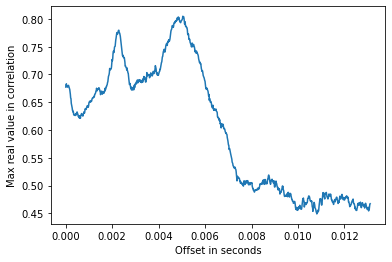

Offset is 12595 values, thus 100760 bytes


12595

In [66]:
find_delay()

In [ ]:
def hdfig(subplots_def=None, scale=0.5):
    fig = plt.figure(figsize=(8, 4.5), dpi=scale * 1920 / 8)
    if subplots_def is None:
        return fig
    else:
        return fig, fig.subplots(*subplots_def)

def digitize(real_sequence: 'np.ndarray', nrbits: int = 8):
    result = np.rint(real_sequence).astype(int)
    maxpos = 2 ** (nrbits - 1) - 1
    maxneg = -(2 ** (nrbits - 1))
    result[result < maxneg] = maxneg
    result[result > maxpos] = maxpos
    return result


def simple_real_cross_power(ant_1_voltage, ant_2_voltage, nrbits: int = 4):
    # assert ant_1_voltage.shape == ant_2_voltage.shape
    s1 = ant_1_voltage #digitize(ant_1_voltage, nrbits=nrbits)
    s2 = ant_2_voltage #digitize(ant_2_voltage, nrbits=nrbits)
    return sp.signal.correlate(s1, s2, mode='same') / s1.shape[0]


def plot_real_xc(xc: 'np.ndarray[np.float]', width: int, sample_interval, caption=None):
    fig, ax = hdfig((1, 1))
    m = xc.shape[0] // 2
    lw = width // 2
    hw = width - lw
    delay = np.arange(-lw, hw) * sample_interval
    ax.plot(delay, xc[m - lw:m + hw])
    ax.set_xlabel('Delay [%s]' % delay.unit)
    if caption:
        ax.set_title(caption)
    plt.show()


def main():
    parser = argparse.ArgumentParser(description="calculating correlation as a in-field test",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("file1", type=str, help="Name of file 1")
    parser.add_argument("file2", type=str, help="Name of file 2")
    parser.add_argument("-w", '--window', type=int, help="Window of correlation plot")
    args = parser.parse_args()
    config = vars(args)

    file1 = np.fromfile(config['file1'], dtype=np.complex64)  # [0:3000000]
    file2 = np.fromfile(config['file2'], dtype=np.complex64)  # [0:3000000]

    delta_freq = 2.5 * u.MHz
    sample_interval = (1 / (2 * delta_freq)).to(u.s)

    if config['window'] is None:
        w = 100000
    else:
        w = config['window']

    try:
        corrcoeff = np.corrcoef(file1, file2)[0, 1]
        cross = simple_real_cross_power(file1 * 10, file2 * 10, nrbits=4)
    except ValueError:
        lendiff = len(file2)-len(file1)
        print(f"Sample loss has occurred between the two, the difference in lenght is: {np.abs(lendiff)}")
        print(f"Calculating the correlation where the two are of equal length")
        if lendiff<0:
            file1 = file1[:lendiff]
        else:
            file2 = file2[:-lendiff]
        corrcoeff = np.corrcoef(file1, file2)[0, 1]
        cross = simple_real_cross_power(file1 * 10, file2 * 10, nrbits=4)


    print(f"The crosscorrelation coefficient of the data is: {np.real(corrcoeff):.3f}")

    plot_real_xc(cross, w, sample_interval)
